# Generate object_features.json file for Featup

In [1]:
import glob
import json
import math
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional
from PIL import Image, ImageFile

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

def find_mask_bbox(mask_array):
    rows = np.any(mask_array, axis=1)
    cols = np.any(mask_array, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return (cmin, rmin, cmax+1, rmax+1)  # PIL uses (left, upper, right, lower)

class InstanceDataset(Dataset):
    def __init__(self, data_dir, dataset, data=None, transform=None, imsize=None):
        self.sample_masks = None
        if dataset == 'Object':

            num_obj = []
            image_dir = []
            mask_dir = []
            count = []

            source_list = sorted(glob.glob(os.path.join(data_dir, '*')))                       # number of objects 
            for _, source_dir in enumerate(source_list):
                num_obj.append(source_dir.split('/')[-1].split('.')[0])
                image_paths = sorted([p for p in glob.glob(os.path.join(source_dir, 'images', '*'))
                                      if re.search('/*\.(jpg|jpeg|png|gif|bmp|pbm)', str(p))]) # number of images for each object
                image_paths = [p.replace('\\', '/') for p in image_paths]
                image_dir.extend(image_paths)
                mask_paths = sorted([p for p in glob.glob(os.path.join(source_dir, 'masks', '*'))
                                     if re.search('/*\.(jpg|jpeg|png|gif|bmp|pbm)', str(p))])
                mask_paths = [p.replace('\\', '/') for p in mask_paths]
                mask_dir.extend(mask_paths)
                count.append(len(image_paths))

            cfg = dict()
            cfg['dataset'] = dataset
            cfg['data_dir'] = data_dir
            cfg['image_dir'] = image_dir
            cfg['mask_dir'] = mask_dir
            cfg['obj_name'] = num_obj  # object lists for Object
            cfg['length'] = count

            self.samples = cfg['image_dir']
            self.sample_masks = cfg['mask_dir']
            print(self.samples)
            
        elif dataset == 'Scene':

            num_scene = []
            image_dir = []
            proposals = []
            count = []

            with open(os.path.join(os.path.dirname(data_dir),
                                   'proposals_on_' + data_dir.split('/')[-1] + '.json')) as f:
                proposal_json = json.load(f)

            source_list = sorted(glob.glob(os.path.join(data_dir, '*')))

            for idx, source_dir in enumerate(source_list):
                scene_name = source_dir.split('/')[-1]
                num_scene.append(scene_name)

                image_paths = sorted([p for p in glob.glob(os.path.join(source_dir, '*'))
                                      if re.search('/*\.(jpg|jpeg|png|gif|bmp|pbm)', str(p))])
                image_dir.extend(image_paths)
                count.append(len(image_paths))
                proposals.extend(proposal_json[scene_name])

            cfg = dict()
            cfg['dataset'] = dataset
            cfg['data_dir'] = data_dir
            cfg['image_dir'] = image_dir
            cfg['proposals'] = proposals
            cfg['scene_name'] = num_scene  # scene list for Scene
            cfg['length'] = count

            self.samples = cfg['image_dir']

        else: # for demo scene image
            with open(os.path.join(data_dir, 'proposals_on_' + dataset + '.json')) as f:
                proposal_json = json.load(f)

            cfg = dict()
            cfg['dataset'] = dataset
            cfg['data_dir'] = data_dir
            cfg['image_dir'] = None
            cfg['proposals'] = proposal_json
            cfg['scene_name'] = [dataset]  # scene list for Scene
            cfg['length'] = [len(data)]

            self.samples = data


        self.cfg = cfg
        self.transform = transform
        self.imsize = imsize

    def __len__(self):
        return len(self.samples)

    def get_mask(self, mask):
        # mask_size = self.imsize // 14
        # resized_mask = mask.resize((mask_size, mask_size), Image.BILINEAR)
        resized_mask_numpy = np.array(mask)
        # show resized mask
        # plt.imshow(resized_mask_numpy)
        # plt.show()
        resized_mask_numpy = resized_mask_numpy / 255.0
        tensor_mask = torch.from_numpy(resized_mask_numpy.astype(np.float32))
        tensor_mask[tensor_mask > 0.5] = 1.0
        tensor_mask = tensor_mask.unsqueeze(0).long()  # .to(self.device)
        if tensor_mask.sum() == 0:
            tensor_mask = torch.ones_like(tensor_mask)
        return tensor_mask
    
    def get_resized_mask(self, mask):
        mask_size = self.imsize // 14
        resized_mask = mask.resize((mask_size, mask_size), Image.BILINEAR)
        resized_mask_numpy = np.array(resized_mask)
        # show resized mask
        # plt.imshow(resized_mask_numpy)
        # plt.show()
        resized_mask_numpy = resized_mask_numpy / 255.0
        tensor_mask = torch.from_numpy(resized_mask_numpy.astype(np.float32))
        tensor_mask[tensor_mask > 0.5] = 1.0
        tensor_mask = tensor_mask.unsqueeze(0).long()  # .to(self.device)
        if tensor_mask.sum() == 0:
            tensor_mask = torch.ones_like(tensor_mask)
        return tensor_mask

    def __getitem__(self, index):
        path = self.samples[index]
        label = int(path.split('/')[-3][:3])
        # if self.sample_masks:
        mask_path = self.sample_masks[index]
        mask = Image.open(mask_path)
        mask = mask.convert('L')
        ImageFile.LOAD_TRUNCATED_IMAGES = True

        with open(path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')

        w, h = img.size

        if (self.imsize is not None) and (min(w, h) > self.imsize):
            img.thumbnail((self.imsize, self.imsize), Image.LANCZOS)
            mask.thumbnail((self.imsize, self.imsize), Image.BILINEAR)
        else:
            new_w = math.ceil(w / 14) * 14
            new_h = math.ceil(h / 14) * 14
            img = img.resize((new_w, new_h), Image.LANCZOS)
            mask = mask.resize((new_w, new_h), Image.BILINEAR)

        if self.transform is not None:
            img = self.transform(img)
            og_mask = self.get_mask(mask)
            mask = self.get_resized_mask(mask)
            

        # print("\nHERE >>>", img.shape, mask.shape)
        return img, label, mask, og_mask

In [2]:
# get_object_features_via_FFA.py
# To Generate object_features_vitl14_reg.json

import numpy as np
import torch
from torch import nn
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import os
import json
from tqdm import trange, tqdm
from matplotlib import colors
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import time
import math
from featup.util import norm, unnorm, pca, remove_axes

# Function to find the bounding box of the non-zero regions in the mask
def find_mask_bbox(mask_array):
    rows = np.any(mask_array, axis=1)
    cols = np.any(mask_array, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return (cmin, rmin, cmax+1, rmax+1)  # PIL uses (left, upper, right, lower)

img_size = 448
# Define transformations to be applied to the images
# used before function get_object_features_via_dataloader
# transform = transforms.Compose([
#             transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])

# Featup Transformations
transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.CenterCrop((img_size, img_size)),
        transforms.ToTensor(),
        norm
    ])

object_dataset = InstanceDataset(data_dir='C:\dataset\InsDet-FULL\Objects', dataset='Object',transform=transform, imsize=img_size)
object_dataset.__len__()

['C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/001.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/002.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/003.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/004.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/005.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/006.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/007.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/008.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/009.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/010.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/011.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/012.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/013.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/014.jpg', 'C:/dataset/InsDet-FULL/Objects/000_aveda_shampoo/images/015.

2400

In [3]:
# use dino v2 to extract features
# encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
# encoder.to('cuda')
# encoder.eval()

upsampler=torch.hub.load("mhamilton723/FeatUp", 'dinov2').to('cuda').eval()

Using cache found in C:\Users\divya/.cache\torch\hub\mhamilton723_FeatUp_main
c:\Users\divya\AppData\Local\Programs\Python\Python310\lib\site-packages\featup\featurizers\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
c:\Users\divya\AppData\Local\Programs\Python\Python310\lib\site-packages\featup\featurizers\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
c:\Users\divya\AppData\Local\Programs\Python\Python310\lib\site-packages\featup\featurizers\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in C:\Users\divya/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\divya/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xForme

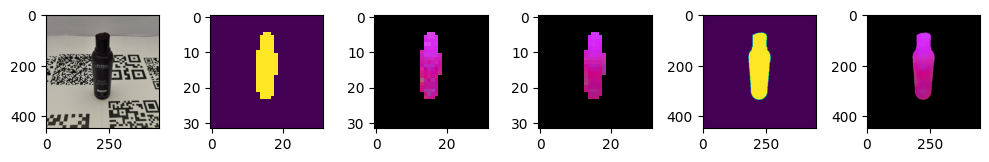

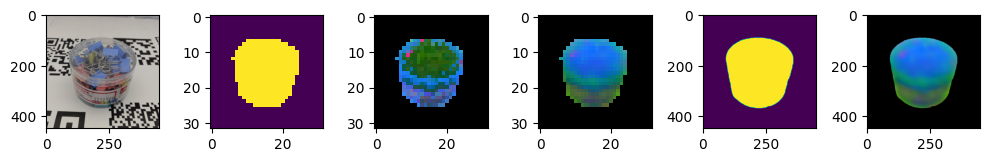

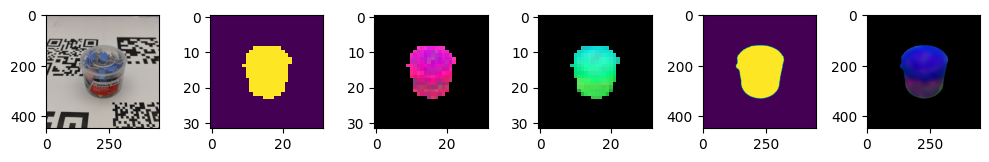

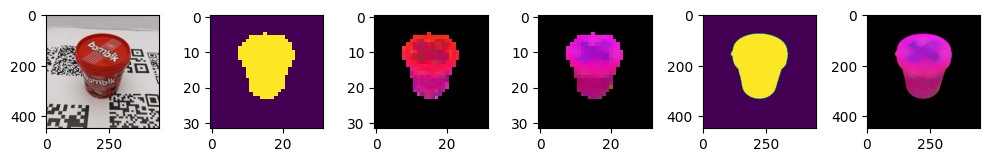

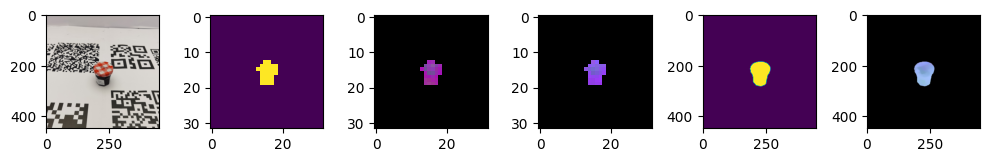

In [6]:
num_obj=0
for i in range(5):
    imgs, _, resized_masks, masks = object_dataset.__getitem__(num_obj)
    num_obj+=24
    imgs=imgs.unsqueeze(0)

    with torch.no_grad():
        lr_feats_P = upsampler.model(imgs.to('cuda'))
        hr_feats = upsampler(imgs.to('cuda'))
        # print(f"\n{lr_feats_P.shape=} || {hr_feats.shape=} || {masks.shape=} || {resized_masks.shape=}")
        hr_feats_P = torch.nn.functional.interpolate(hr_feats, masks.unsqueeze(0).shape[2:], mode="bilinear")
        hr_feats_Patch = torch.nn.functional.interpolate(hr_feats, resized_masks.unsqueeze(0).shape[2:], mode="bilinear")

    # CODE FOR PLOTTING
    [hr_feats_P], _ = pca([hr_feats_P], dim=9)
    [hr_feats_Patch], _ = pca([hr_feats_Patch], dim=9)
    [lr_feats_P], _ = pca([lr_feats_P], dim=9)
    lr_feats_P=lr_feats_P[0, :3].permute(1,2,0).detach().cpu()
    hr_feats_P=hr_feats_P[0, :3].permute(1,2,0).detach().cpu()
    hr_feats_Patch=hr_feats_Patch[0, :3].permute(1,2,0).detach().cpu()
    rgb_img=unnorm(imgs)[0].permute(1,2,0).detach().cpu()

    # print(f"\n{lr_feats_P.shape=} & {hr_feats_P.shape=}")
    # print(f"\n{resized_masks.shape=} & {masks.shape=}")

    lr_feats_P=lr_feats_P*resized_masks.permute(1,2,0)
    hr_feats_P=hr_feats_P*masks.permute(1,2,0)
    hr_feats_Patch=hr_feats_Patch*resized_masks.permute(1,2,0)

    fig, ax = plt.subplots(1, 6, figsize=(10, 60))
    ax[0].imshow(rgb_img)
    ax[1].imshow(resized_masks.permute(1,2,0))
    ax[2].imshow(lr_feats_P)
    ax[3].imshow(hr_feats_Patch)
    ax[4].imshow(masks.permute(1,2,0))
    ax[5].imshow(hr_feats_P)
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
img_size=448
batch_size = 2  # Define the batch size

dataloader = DataLoader(object_dataset, batch_size=batch_size, shuffle=False)
print(dataloader.__len__())

1200


In [5]:
object_features = []
start_time = time.time()

for imgs, _, resized_masks, masks in tqdm(dataloader):    
    # imgs Shape: (B, 3, 448, 448)
    # masks Shape: (B, 1, 448, 448)
    # resized masks Shape: (B, 1, 32, 32)
    with torch.no_grad():
        hr_feats = upsampler(imgs.to('cuda'))                       # Shape: (B, 384, 512, 512)
        hr_feats_patch = torch.nn.functional.interpolate(hr_feats,  # Shape: (B, 384, 32, 32)
                                resized_masks.shape[2:], mode="bilinear")
        # hr_feats = torch.nn.functional.interpolate(hr_feats,        # Shape: (B, 384, 448, 448)
        #                         imgs.shape[2:], mode="bilinear") 
        # lr_feats = upsampler.model(imgs.to('cuda'))               # Shape: (B, 384, 32, 32)

    # feats=hr_feats.permute(0,2,3,1).detach().cpu()                  # Shape: (B, 448, 448, 384)
    feats_patch=hr_feats_patch.permute(0,2,3,1).detach().cpu()                  # Shape: (B, 32, 32, 384)
    
    # ffa_features = (feats * masks.permute(0, 2, 3, 1)).sum(dim=(1, 2)) / masks.sum(dim=(1, 2, 3)).unsqueeze(-1) # Shape: (1, 384)
    ffa_features_patch = (feats_patch * resized_masks.permute(0, 2, 3, 1)).sum(dim=(1, 2)) / resized_masks.sum(dim=(1, 2, 3)).unsqueeze(-1) # Shape: (1, 384)

    # object_features.append(ffa_features) # Shape: (B, 384)
    object_features.append(ffa_features_patch) # Shape: (B, 384)
    torch.cuda.empty_cache()

end_time = time.time()
# Calculate and print the total time
print(f"Total running time: {end_time - start_time} seconds")

  0%|          | 0/1200 [00:00<?, ?it/s]c:\Users\divya\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1200/1200 [1:05:14<00:00,  3.26s/it]

Total running time: 3914.5241775512695 seconds


In [6]:
object_features = torch.cat(object_features, dim=0)
print(object_features.shape) # (2400, 384)

feat_dict = dict()
feat_dict['features'] = object_features.detach().cpu().tolist()

output_dir = 'D:/CODE/NIDS-Net/feats'
json_filename = 'object_features_featup_patch.json'

with open(os.path.join(output_dir, json_filename), 'w') as f:
    json.dump(feat_dict, f)

torch.Size([2400, 384])
